<a href="https://colab.research.google.com/github/Rehan-Mullani/Architecting-LLMs-WiDS/blob/main/week3/makemore_part2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E01**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[-1.0000, -0.9999,  0.9962,  ...,  0.9958, -0.4005,  0.9888],
        [-1.0000,  0.8803,  0.9707,  ..., -0.6182, -0.8958,  0.4569],
        [-0.9910, -0.8892,  1.0000,  ..., -0.9658, -0.9997, -0.9938],
        ...,
        [ 0.9464, -1.0000,  0.9976,  ...,  0.4741, -0.9998, -0.1287],
        [ 0.9911,  0.9948, -0.6305,  ...,  0.7482,  0.1260, -0.9991],
        [-0.9998, -1.0000,  0.9963,  ..., -0.9311,  0.9008,  0.0741]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(15.4073)

In [21]:
# ------------ now made respectable :) ---------------

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 15), generator=g)
W1 = torch.randn((45, 250), generator=g)
b1 = torch.randn(250, generator=g)
W2 = torch.randn((250, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total

18682

In [25]:
for p in parameters:
  p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

In [28]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (100,))

  # forward pass
  emb = C[Xtr[ix]] # (100, 3, 15)
  h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (32, 250)
  logits = h @ W2 + b2 # (100, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

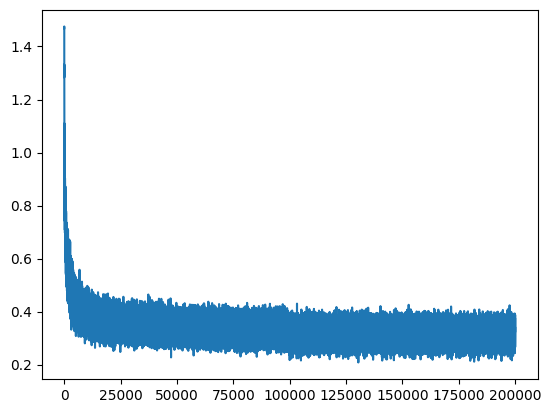

In [29]:
plt.plot(stepi, lossi)

In [30]:
emb = C[Xtr] # (100, 3, 15)
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (100, 250)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0748, grad_fn=<NllLossBackward0>)

In [31]:
emb = C[Xdev] # (100, 3, 15)
h = torch.tanh(emb.view(-1, 45) @ W1 + b1) # (100, 250)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1398, grad_fn=<NllLossBackward0>)

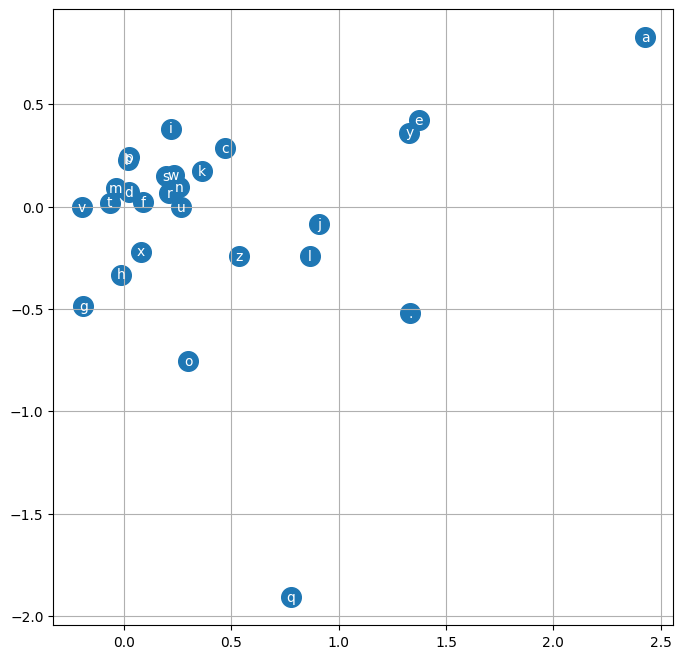

In [32]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [34]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 15])

In [35]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mili.
taty.
skanden.
jazhubeferlynn.
jareeico.
kasia.
chaihr.
kaleigh.
ham.
jocs.
quinton.
lilea.
jadia.
watelo.
dearisi.
jacee.
dusabee.


# **E02**

If the probabilities were perfectly uniform across 27 characters, the expected initial loss would be:$$-\ln(1/27) \approx 3.2958$$
The initial loss we got was 15.84, which means the model was "confidently wrong."

In [42]:
g = torch.Generator().manual_seed(2147483647)

# Hyperparameters
emb_size = 10
n_hidden = 200

C  = torch.randn((27, emb_size),            generator=g)
# W1 is scaled by 5/3 (gain for tanh) divided by sqrt of fan-in
W1 = torch.randn((block_size * emb_size, n_hidden), generator=g) * (5/3)/((block_size * emb_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# W2 is scaled down significantly to make initial logits close to 0
W2 = torch.randn((n_hidden, 27),                  generator=g) * 0.01
b2 = torch.randn(27,                              generator=g) * 0    # Initialize biases to 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

Total parameters: 11897


In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.005 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0956
 120000/ 200000: 1.9561
 130000/ 200000: 2.3914
 140000/ 200000: 2.1039
 150000/ 200000: 2.1384
 160000/ 200000: 1.7928
 170000/ 200000: 1.7407
 180000/ 200000: 1.9666
 190000/ 200000: 1.8502


In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0365986824035645
val 2.101980686187744


# **E03**

In [45]:
g = torch.Generator().manual_seed(2147483647)

# Hyperparameters
emb_size = 10
n_hidden = 200

C  = torch.randn((27, emb_size),            generator=g)
W1 = torch.randn((block_size * emb_size, n_hidden), generator=g) * (5/3)/((block_size * emb_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, 27),                  generator=g) * 0.01
b2 = torch.randn(27,                              generator=g) * 0

# --- E03: Bengio 2003 Direct Connection Parameters ---
# This connects (block_size * emb_size) directly to the 27 output classes
W_direct = torch.randn((block_size * emb_size, 27), generator=g) * 0.01

parameters = [C, W1, b1, W2, b2, W_direct]
for p in parameters:
    p.requires_grad = True

print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

Total parameters: 12707


In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)

  # Path 1: The Hidden Layer (Non-linear)
  h = torch.tanh(embcat @ W1 + b1)

  # Path 2: Direct Connection (Linear)
  # Bengio et al. 2003 equation: y = b + Wx + U * tanh(d + Hx)
  logits = (h @ W2 + b2) + (embcat @ W_direct) # Combined output

  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3333
  10000/ 200000: 2.1722
  20000/ 200000: 2.3112
  30000/ 200000: 2.3336
  40000/ 200000: 2.2141
  50000/ 200000: 2.7633
  60000/ 200000: 2.1674
  70000/ 200000: 2.1255
  80000/ 200000: 2.2769
  90000/ 200000: 2.3364
 100000/ 200000: 2.1920
 110000/ 200000: 2.0001
 120000/ 200000: 2.3169
 130000/ 200000: 1.7901
 140000/ 200000: 1.8236
 150000/ 200000: 2.0944
 160000/ 200000: 2.3345
 170000/ 200000: 1.9606
 180000/ 200000: 2.0588
 190000/ 200000: 1.7269


In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2 + (embcat @ W_direct)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0409247875213623
val 2.1056315898895264
